# SNR (optimal) generation and comparison 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from gwsnr import GWSNR

## Initialization

* run the following, if you want to see the documentation and the input parameters

In [2]:
# GWSNR?

* class initialization with default parameters
* IMPORTANT: set the npool parameter to the number of cores you want to use for the parallel processing
* parallel processing is use in the interpolator generation and in the SNR generation with inner-product method.

```
from gwsnr import GWSNR
gwsnr = GWSNR()
snr = gwsnr.snr(mass_1=30, mass_2=20, luminosity_distance=1000)
print(snr)
```


In [3]:
# gwsnr = GWSNR(gwsnr_verbose=False) # if you don't want to see the print statements
gwsnr = GWSNR()

psds not given. Choosing bilby's default psds
Interpolator will be loaded for L1 detector from ./interpolator_pickle/L1/partialSNR_dict_0.pickle
Interpolator will be loaded for H1 detector from ./interpolator_pickle/H1/partialSNR_dict_0.pickle
Interpolator will be loaded for V1 detector from ./interpolator_pickle/V1/partialSNR_dict_0.pickle

Chosen GWSNR initialization parameters:

npool:  4
snr type:  interpolation
waveform approximant:  IMRPhenomD
sampling frequency:  2048.0
minimum frequency (fmin):  20.0
mtot=mass1+mass2
min(mtot):  2.0
max(mtot) (with the given fmin=20.0): 184.98599853446768
detectors:  ['L1', 'H1', 'V1']
psds:  [PowerSpectralDensity(psd_file='None', asd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/aLIGO_O4_high_asd.txt'), PowerSpectralDensity(psd_file='None', asd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/aLIGO_O4_high_

## calculate the SNR for given BBH (binary-black-hole) masses

In [4]:
mass_1 = np.array([5, 10.,50.,100.])
ratio = np.array([1, 0.8,0.5,0.2])
dl = 1000
print('Interpolation results: ')
print(gwsnr.snr(mass_1=mass_1, mass_2=mass_1*ratio, luminosity_distance=dl))
print('\n Inner product results: ')
print(gwsnr.compute_bilby_snr(mass_1=mass_1, mass_2=mass_1*ratio, luminosity_distance=dl))

Interpolation results: 
{'L1': array([ 7.40723723, 11.59750023, 31.03606512, 26.59902137]), 'H1': array([ 4.71123998,  7.37638139, 19.73993088, 16.91782903]), 'V1': array([2.22230615, 3.44041247, 9.33487066, 7.86143837]), 'optimal_snr_net': array([ 9.05547294, 14.16860798, 37.94788557, 32.48881484])}

 Inner product results: 


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.05it/s]

{'L1': array([ 7.40711467, 11.59746314, 31.03567109, 26.59869097]), 'H1': array([ 4.71116203,  7.37635779, 19.73968027, 16.91761888]), 'V1': array([2.22230551, 3.4404035 , 9.33473625, 7.86132463]), 'optimal_snr_net': array([ 9.05533197, 14.16856315, 37.94739989, 32.48840739])}


## Testing speed and accurarcy between the interpolation method and inner product method.

* set up the BBH parameters
* simulate 1000 events

In [5]:
# gerneral case, random parameters
# chirp mass can go upto only 95 if f_min=20. to get non zero SNR
nsamples = 1000
chirp_mass = np.linspace(5,80,nsamples)
mass_ratio = np.random.uniform(0.2,1,size=nsamples)
mass_1 = (chirp_mass*(1+mass_ratio)**(1/5))/mass_ratio**(3/5)
mass_2 = chirp_mass*mass_ratio**(2/5)*(1+mass_ratio)**(1/5)
total_mass = mass_1+mass_2
mass_ratio = mass_2/mass_1
# Fix luminosity distance
luminosity_distance = 80*np.ones(nsamples)
# Randomly sample everything else:
theta_jn = np.random.uniform(0,2*np.pi, size=nsamples)
ra, dec, psi, phase = np.random.uniform(0,2*np.pi, size=nsamples), np.random.uniform(0,np.pi, size=nsamples), np.random.uniform(0,2*np.pi, size=nsamples), np.random.uniform(0,2*np.pi, size=nsamples)
a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl = 0,0,0,0,0,0 # Zero spin

* below calculation is with inner product method
* this is similar to how snr is calculated in the `bilby` package

In [6]:
# error might occur for mchirp>95., if f_min=20. 
start_time = datetime.now()
bilby_snr = gwsnr.compute_bilby_snr(mass_1=mass_1, mass_2=mass_1, luminosity_distance=luminosity_distance, theta_jn=theta_jn, \
                            psi=psi, phase=phase, ra=ra, dec=dec)
end_time = datetime.now()
print('Duration inner-product: {}'.format(end_time - start_time))

100%|████████████████████████████████████████████████████████████| 732/732 [00:03<00:00, 203.86it/s]


Duration inner-product: 0:00:03.632016


In [7]:
start_time = datetime.now()
interp_snr = gwsnr.snr(mass_1=mass_1, mass_2=mass_1, luminosity_distance=luminosity_distance, theta_jn=theta_jn, \
            psi=psi, phase=phase, ra=ra, dec=dec)
end_time = datetime.now()
print('Duration interpolation: {}'.format(end_time - start_time))

Duration interpolation: 0:00:00.633895


* interpolation method is much faster than inner product method
* **Note:** interpolation method is only for the spinless compact binary coalescence (CBC) frequency domain waveform models.

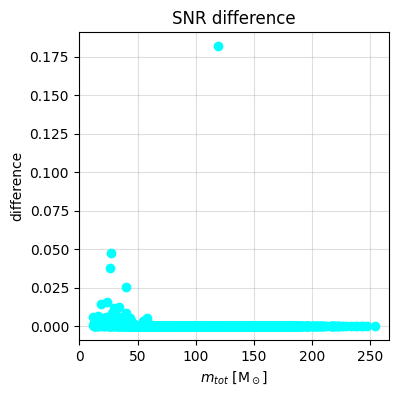

In [8]:
plt.figure(figsize=(4,4))
plt.plot(total_mass, abs(interp_snr['optimal_snr_net']-bilby_snr['optimal_snr_net']), 'o', color='cyan')
plt.xlabel(r"$m_{tot}$ [$\rm M_\odot$]")
plt.ylabel(r"difference")
plt.title(r"SNR difference")
plt.grid(alpha=0.4)
plt.show()

## pdet (probaility of detection) calculation

In [9]:
mass_1 = np.array([2,50.,100.,])
ratio = 1.
dl = 500
snr_dict = gwsnr.snr(mass_1=mass_1, mass_2=mass_1*ratio, luminosity_distance=dl)
# with snr threshold equal to 8
pdet_dict = gwsnr.probability_of_detection(snr_dict, snr_th=8, snr_th_net=8, type='bool')

In [10]:
print('snr: ', snr_dict["optimal_snr_net"])
print('pdet: ', pdet_dict["pdet_net"])

snr:  [  8.78159001 105.15382713   0.        ]
pdet:  [1 1 0]


## Changing the input parameters 

What will change?
* Detectors: CE, ET.
* Minimum frequency: 10 Hz
* Maximum total mass: 500. Note that if this mass is above the allowed total mass for the given minimum frequency, i.e. the last stable orbit (LSO) frequency below the minimum frequency, then the maximum mass will be set to the maximum mass for the given minimum frequency.
* Waveform model: IMRPhenomXPHM

In [11]:
# if snr_type = 'inner_product', interpolator will not be created
from gwsnr import GWSNR
gwsnr = GWSNR(
    npool = int(4), 
    mtot_min=2.,
    mtot_max=440.,  # highest total mass possible at 10Hz
    minimum_frequency = 10.,
    snr_type = 'inner_product', 
    #psds = {'CE':'CE_psd.txt', 'ET':'ET_B_psd.txt'}, # if you want to use your own psd
    ifos = ['CE', 'ET'],  # this will considet bilby's default psd of CE and ET
)


Chosen GWSNR initialization parameters:

npool:  4
snr type:  inner_product
waveform approximant:  IMRPhenomD
sampling frequency:  2048.0
minimum frequency (fmin):  10.0
mtot=mass1+mass2
min(mtot):  2.0
max(mtot) (with the given fmin=10.0): 369.97199706893525
detectors:  ['CE', 'ET1', 'ET2', 'ET3']
psds:  [PowerSpectralDensity(psd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/CE_psd.txt', asd_file='None'), PowerSpectralDensity(psd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/ET_D_psd.txt', asd_file='None'), PowerSpectralDensity(psd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/ET_D_psd.txt', asd_file='None'), PowerSpectralDensity(psd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/ET_D_psd.txt', asd_file='N

In [12]:
mass_1 = np.array([5, 10.,50.,100.])
ratio = np.array([1, 0.8,0.5,0.2])
gwsnr.snr(mass_1=mass_1, mass_2=mass_1*ratio)

solving SNR with inner product


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.22it/s]


{'CE': array([2148.90304551, 3418.3544206 , 9539.03962624, 9480.46037205]),
 'ET1': array([149.37771668, 236.23429377, 662.6230723 , 639.92876964]),
 'ET2': array([ 426.53991017,  674.55412147, 1892.0839869 , 1827.28164531]),
 'ET3': array([ 474.63277116,  750.61086744, 2105.4186128 , 2033.30973335]),
 'optimal_snr_net': array([2246.622034  , 3572.02932848, 9972.21718955, 9887.46400141])}

## SNR and Pdet with ANN (artificial neural network) model

* **Note:** as of 2024-02-16, the ANN model is only available for the IMRPhenomXPHM waveform model. This pre-trained model considers the spin precession of the compact objects. SNR with ANN is much faster than 'inner_product' method. The ANN model is trained with the following `gwsnr` parameters. The corresponding Pdet generated is more accurate (accuracy=99%) than it's absolute SNR. So users are advised to use the ANN model for Pdet calculation rather than SNR calculation.
  
* Users can train their own ANN model with the instructions in the documentation.

In [2]:
import numpy as np
from gwsnr import GWSNR

In [4]:
# innitialize the class for pdet calculation
gwsnr = GWSNR(snr_type='ann', waveform_approximant='IMRPhenomXPHM', pdet=True)

psds not given. Choosing bilby's default psds
Interpolator will be loaded for L1 detector from ./interpolator_pickle/L1/partialSNR_dict_1.pickle
Interpolator will be loaded for H1 detector from ./interpolator_pickle/H1/partialSNR_dict_1.pickle
Interpolator will be loaded for V1 detector from ./interpolator_pickle/V1/partialSNR_dict_1.pickle

Chosen GWSNR initialization parameters:

npool:  4
snr type:  ann
waveform approximant:  IMRPhenomXPHM
sampling frequency:  2048.0
minimum frequency (fmin):  20.0
mtot=mass1+mass2
min(mtot):  2.0
max(mtot) (with the given fmin=20.0): 184.98599853446768
detectors:  ['L1', 'H1', 'V1']
psds:  [PowerSpectralDensity(psd_file='None', asd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/aLIGO_O4_high_asd.txt'), PowerSpectralDensity(psd_file='None', asd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/aLIGO_O4_high_asd.txt

* compare pdet (bool)

In [5]:
# set the GW parameters
mass_1 = np.array([5, 10.,50.,200.])
ratio = np.array([1, 0.8,0.5,0.2])
luminosity_distance = np.array([1000, 2000, 3000, 4000])
a_1 = np.array([0.1, 0.2, 0.3, 0.4])
a_2 = np.array([0.1, 0.2, 0.3, 0.4])
tilt_1 = np.array([0.1, 0.2, 0.3, 0.4])
tilt_2 = np.array([0.1, 0.2, 0.3, 0.4])
phi_12 = np.array([0.1, 0.2, 0.3, 0.4])
phi_jl = np.array([0.1, 0.2, 0.3, 0.4])

# pdet calculation with ANN
gwsnr.snr(mass_1=mass_1, mass_2=mass_1*ratio, luminosity_distance=luminosity_distance, a_1=a_1, a_2=a_2, tilt_1=tilt_1, tilt_2=tilt_2, phi_12=phi_12, phi_jl=phi_jl)

{'L1': array([0, 0, 1, 0]),
 'H1': array([0, 0, 0, 0]),
 'V1': array([0, 0, 0, 0]),
 'pdet_net': array([1, 0, 1, 0])}

In [6]:
# pdet calculation with inner product
snr_bilby = gwsnr.compute_bilby_snr(mass_1=mass_1, mass_2=mass_1*ratio, luminosity_distance=luminosity_distance, a_1=a_1, a_2=a_2, tilt_1=tilt_1, tilt_2=tilt_2, phi_12=phi_12, phi_jl=phi_jl)

# pdet calculation with inner product
pdet_bilby = gwsnr.probability_of_detection(snr_dict=snr_bilby, type='bool')
pdet_bilby

100%|█████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.06s/it]


{'L1': array([0, 0, 1, 0]),
 'H1': array([0, 0, 0, 0]),
 'V1': array([0, 0, 0, 0]),
 'pdet_net': array([1, 0, 1, 0])}

* compare the SNRs

In [7]:
# looking at the SNRs 
snr_ann = gwsnr.snr_with_ann(mass_1=mass_1, mass_2=mass_1*ratio, luminosity_distance=luminosity_distance, a_1=a_1, a_2=a_2, tilt_1=tilt_1, tilt_2=tilt_2, phi_12=phi_12, phi_jl=phi_jl)
print("snr_ann=", snr_ann["optimal_snr_net"])

# looking at the inner product SNRs
print("snr_bilby=", snr_bilby["optimal_snr_net"])

snr_ann= [ 8.14168884  6.60770335 13.39330449  0.        ]
snr_bilby= [ 9.16681127  7.32604676 14.27370505  0.        ]


* Also lastly, let's have look at the interpolated spinless SNRs with IMRPhenomXPHM.

In [8]:
snr_interp = gwsnr.snr_with_interpolation(mass_1=mass_1, mass_2=mass_1*ratio, luminosity_distance=luminosity_distance)
print("snr_interp=", snr_interp["optimal_snr_net"])

snr_interp= [ 9.05547294  7.08430399 12.64929519  0.        ]


* spinless SNRs with IMRPhenomXPHM is more accurate when spin is small.

* **Note:** ANN is less accurate in low mass ratio region. The accuracy can be improved by increasing the number of training samples in the sparse region of the parameter space.